### Домашнее задание к лекции "Сверточные сети"

##### Преподаватель: Алексей Миронов, Екатерина Апраксина

#### Используя сверточные слои и архитектуру получите на fashion mnist качество не ниже 89,5%


In [1]:
# Библиотеки
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision as tv
from torchvision import datasets
from torch import nn as nn
import numpy as np
import time

In [2]:
torch.__version__

'1.10.0'

In [3]:
BATCH_SIZE=256

In [4]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

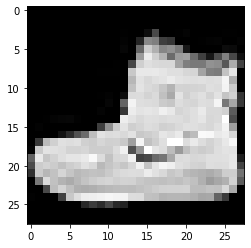

In [5]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray')

In [28]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),   
    nn.Flatten(),
    nn.Linear(300, 50),   
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [29]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=50, bias=True). X shape: torch.Size([1, 50])
Layer ReLU(). X shape: torch.Size

In [8]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [9]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [10]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [11]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs)

epoch 1, loss 0.6476, train acc 0.757, test acc 0.848, time 15.3 sec
epoch 2, loss 0.3809, train acc 0.859, test acc 0.861, time 15.2 sec
epoch 3, loss 0.3290, train acc 0.879, test acc 0.877, time 15.3 sec
epoch 4, loss 0.3023, train acc 0.887, test acc 0.882, time 15.3 sec
epoch 5, loss 0.2819, train acc 0.895, test acc 0.888, time 15.2 sec
epoch 6, loss 0.2671, train acc 0.902, test acc 0.893, time 15.2 sec
epoch 7, loss 0.2551, train acc 0.905, test acc 0.895, time 15.2 sec
epoch 8, loss 0.2440, train acc 0.910, test acc 0.895, time 15.2 sec
epoch 9, loss 0.2356, train acc 0.913, test acc 0.898, time 15.1 sec
epoch 10, loss 0.2286, train acc 0.915, test acc 0.897, time 15.6 sec


## Обучение на GPU

In [12]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
dev

device(type='cpu')

In [14]:
model = model.to(dev)

In [15]:
def train(net, train_iter, test_iter, trainer, num_epochs, dev):
    loss = nn.CrossEntropyLoss(reduction='sum')
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net, dev)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [16]:
def evaluate_accuracy(data_iter, net, dev):
    acc_sum, n = torch.Tensor([0]).to(dev), 0
    for X, y in data_iter:
        X, y = X.to(dev), y.to(dev)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [17]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, dev)

epoch 1, loss 0.2215, train acc 0.918, test acc 0.898, time 15.4 sec
epoch 2, loss 0.2151, train acc 0.921, test acc 0.898, time 15.4 sec
epoch 3, loss 0.2097, train acc 0.923, test acc 0.898, time 15.2 sec
epoch 4, loss 0.2045, train acc 0.925, test acc 0.898, time 15.5 sec
epoch 5, loss 0.1990, train acc 0.927, test acc 0.896, time 15.3 sec
